In [1]:

import os
import locale
from enum import Enum

import pandas as pd 
import numpy as np 

from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

class ModelType(Enum):
    LOGISTIC = 1
    EXPONENTIAL = 2

locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=en_US.UTF-8;LC_NUMERIC=it_IT.UTF-8;LC_TIME=it_IT.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=it_IT.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=it_IT.UTF-8;LC_NAME=it_IT.UTF-8;LC_ADDRESS=it_IT.UTF-8;LC_TELEPHONE=it_IT.UTF-8;LC_MEASUREMENT=it_IT.UTF-8;LC_IDENTIFICATION=it_IT.UTF-8'

In [2]:
# Data file to be read:
data_file_path = os.path.join("..","data")
it_data_file_name = "virus-it.csv"
lo_data_file_name = "virus-lombardia.csv"
it_data_file = os.path.join(data_file_path, it_data_file_name)
lo_data_file = os.path.join(data_file_path, lo_data_file_name)

# Place where images are saved:
images_path = os.path.join("..","images")

# Training data for the model: the number of samples used for
# the model training.
training_data_end = 22

In [3]:
#
# Load Italian dataset.
#
df = pd.read_csv(it_data_file, sep=',', lineterminator='\n'
                ,low_memory=False)

df["timeStamp"] = pd.to_datetime(df["Data"], format="%d/%m/%Y")
df.sort_values(by=["timeStamp"], inplace=True)

min_date = df['timeStamp'].min()
df['TimeDelta'] = (df['timeStamp'] - min_date).dt.days + 1
df["TotalDiff"] = df["Totale"].diff(periods = 1)
df["MortiDiff"] = df["Morti"].diff(periods = 1)
df["GuaritiDiff"] = df["Guariti"].diff(periods = 1)
df["Casi attualiDiff"] = df["Casi attuali"].diff(periods = 1)

all_deaths = df["Morti"].max()
all_infected = df["Totale"].max()
it_infected_deaths_ratio = round((all_deaths / all_infected) * 100, 1)

(df.shape, df.dtypes)

((89, 11),
 Data                        object
 Casi attuali                 int64
 Morti                        int64
 Guariti                      int64
 Totale                       int64
 timeStamp           datetime64[ns]
 TimeDelta                    int64
 TotalDiff                  float64
 MortiDiff                  float64
 GuaritiDiff                float64
 Casi attualiDiff           float64
 dtype: object)

In [4]:
#
# Load Lombardy dataset.
#
df_lo = pd.read_csv(lo_data_file, sep=',', lineterminator='\n', low_memory=False)

df_lo["timeStamp"] = pd.to_datetime(df_lo["Data"], format="%d/%m/%Y")
df_lo.sort_values(by=["timeStamp"], inplace=True)

min_date = df_lo['timeStamp'].min()
df_lo['TimeDelta'] = (df_lo['timeStamp'] - min_date).dt.days + 1
df_lo["TotalDiff"] = df_lo["Totale"].diff(periods = 1)
df_lo["TamponiDiff"] = df_lo["Tamponi"].diff(periods = 1)

(df.shape, df.dtypes)

((89, 11),
 Data                        object
 Casi attuali                 int64
 Morti                        int64
 Guariti                      int64
 Totale                       int64
 timeStamp           datetime64[ns]
 TimeDelta                    int64
 TotalDiff                  float64
 MortiDiff                  float64
 GuaritiDiff                float64
 Casi attualiDiff           float64
 dtype: object)

In [5]:
df.head(3)

,Data,Casi attuali,Morti,Guariti,Totale,timeStamp,TimeDelta,TotalDiff,MortiDiff,GuaritiDiff,Casi attualiDiff
88,01/03/2020,1577,34,83,1694,2020-03-01,1,NaN,NaN,NaN,NaN
87,02/03/2020,1835,52,149,2036,2020-03-02,2,342.0,18.0,66.0,258.0
86,03/03/2020,2263,79,160,2502,2020-03-03,3,466.0,27.0,11.0,428.0


In [6]:
df_lo.head(4)

,Data,Ricoverati con sintomi,Terapia intensiva,Isolamento domiciliare,Totale positivi,Dimessi,Deceduti,Totale,Tamponi,timeStamp,TimeDelta,TotalDiff,TamponiDiff
88,01/03/2020,406,106,375,887,73,24,984,6879,2020-03-01,1,NaN,NaN
87,02/03/2020,478,127,472,1077,139,38,1254,7925,2020-03-02,2,270.0,1046.0
86,03/03/2020,698,167,461,1326,139,55,1520,9577,2020-03-03,3,266.0,1652.0
85,04/03/2020,877,209,411,1497,250,73,1820,12138,2020-03-04,4,300.0,2561.0


In [7]:
# ------------------------------------------------------------
# ------------------------------------------------------------
# Some common functions.
# ------------------------------------------------------------
# ------------------------------------------------------------
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False, border=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(border)
        axe.spines['left'].set_visible(border)
        axe.spines['right'].set_visible(border)
        axe.spines['bottom'].set_visible(border)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

def text_box(ax, text, colors=["#FFFFFF", "#000000"], fontsize=14, x=0, y=0):
    """
    """
    rv = False
    try:
        edgecolor = "none"
        boxstyle = "square"
        if len(colors) >= 3 and colors[2] is not None:
            edgecolor = colors[2]
            boxstyle = "round,pad=1"
        ax.text(x, y
               ,text
               ,ha="left", va="center" 
               ,bbox=dict(boxstyle = boxstyle, facecolor = colors[0], edgecolor = edgecolor)
               ,color=colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, no_grid=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv   

In [8]:
#----------------------------------------------------------------
# Common chart function.
#----------------------------------------------------------------
def composed_c_virus_chart(ax, data_sets,log=False, title=None):
    """
    
    :param ax:
    :param data_sts: dictionary containing all the data set 
                     parameters to customize a single plot;
    :param log:
    :param title:
    :return:
    """
    rv = False
    try:
        set_axes_common_properties(ax, no_grid=False)
        #ax.set_xlim(time_limits)

        max_y = None
        for key in data_sets.keys():
            df = data_sets[key]["df"]
            x = df["timeStamp"].dt.to_pydatetime()
            
            if data_sets[key].get("value column") is not None:
                col_name = data_sets[key]["value column"]
                y = df[col_name]
            else:
                y = df["Totale"]
            new_max = y.max()
            if max_y is None or new_max > max_y:
                max_y = new_max
                
            colors = data_sets[key]["colors"]

            time_limits = [x.min() - pd.Timedelta(hours=10) 
                          ,x.max() + pd.Timedelta(hours=10)]
            ax.set_xlim(time_limits)
            
            ax.scatter(x, y, color=colors[0], s=data_sets[key]["size"], marker=data_sets[key]["dot-shape"], label=data_sets[key]["label"])
            if data_sets[key]["no_plot"] == False:
                ax.plot(x, y, 'b-', linewidth=data_sets[key]["line-size"], color=colors[1])
        
        if title is not None:
            ax.set_title(title, fontsize=16)
        
        ax.set_ylim(top=max_y + 1000)
        
        ax.set_ylabel("Numero", fontsize=12)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        # 'upper left' - 'upper right' - 'lower right'
        ax.legend(fontsize=12, loc='upper left')
            
    except Exception as ex:
        print("composed_c_virus_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv

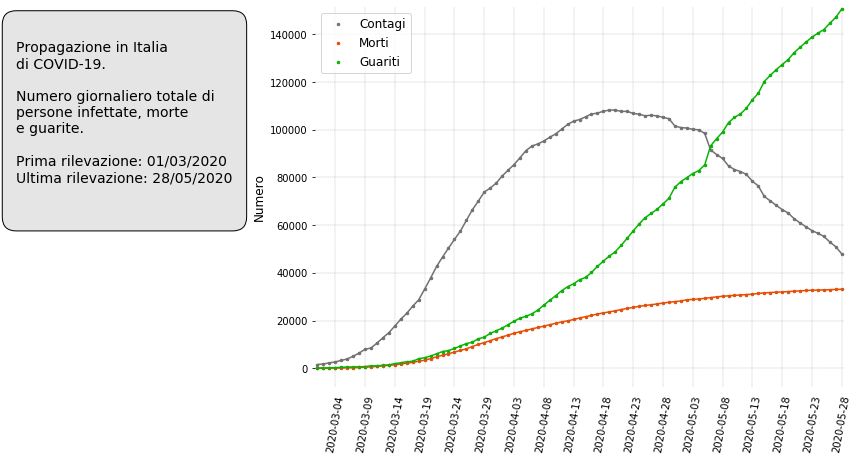

In [9]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df["timeStamp"].min().strftime(date_format)
max_date = df["timeStamp"].max().strftime(date_format)
total = f'{df["Totale"].max():n}'

data_sets = {
    "DailyInfected": {
        "df": df,
        "value column": "Casi attuali",
        "label": "Contagi",
        "colors": ["#727170", "#727170"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "DailyDeaths": {
        "df": df,
        "value column": "Morti",
        "label": "Morti",
        "colors": ["#e64d05", "#e64d05"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "DailyRecovered": {
        "df": df,
        "value column": "Guariti",
        "label": "Guariti",
        "colors": ["#09b204", "#09b204"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}
# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 7))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.7 
                       ,width_ratios=[1.2, 7])
                       #,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
#ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Italia
di COVID-19.

Numero giornaliero totale di 
persone infettate, morte
e guarite.

Prima rilevazione: {d1}
Ultima rilevazione: {d2}

""".format(d1=min_date, d2=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.7)

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
#c_virus_chart(ax[idx],x=x, y=df["Totale"])
composed_c_virus_chart(ax[idx], data_sets)


plt.savefig(os.path.join(images_path,"covid19_daily_infected_chart.png")
           ,bbox_inches='tight')


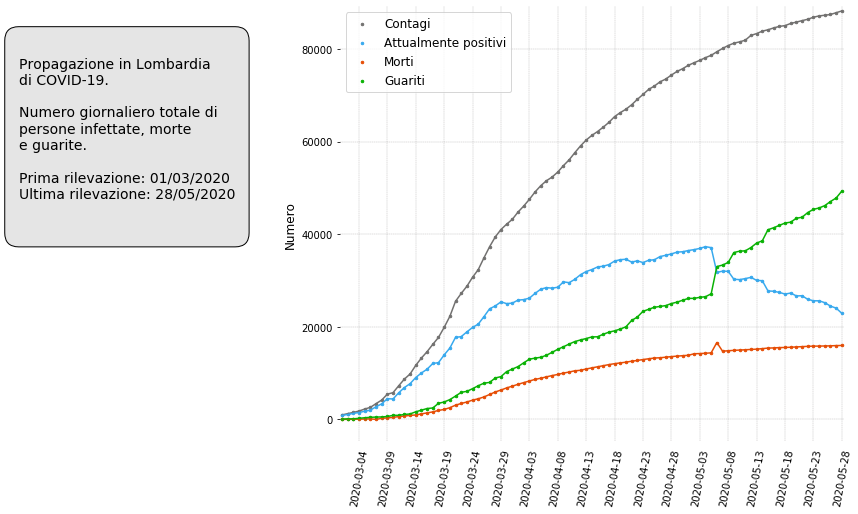

In [10]:
# ------------------------------------------------------
# Virus spread in Lombardy
# Charts for total infected / total recovered and 
# total passed away.
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

data_sets = {
    "TotalInfected": {
        "df": df_lo,
        "value column": "Totale",
        "label": "Contagi",
        "colors": ["#727170", "#727170"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "ActuallyInfected": {
        "df": df_lo,
        "value column": "Totale positivi",
        "label": "Attualmente positivi",
        "colors": ["#37a9ee", "#37a9ee"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "DailyDeaths": {
        "df": df_lo,
        "value column": "Deceduti",
        "label": "Morti",
        "colors": ["#e64d05", "#e64d05"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "DailyRecovered": {
        "df": df_lo,
        "value column": "Dimessi",
        "label": "Guariti",
        "colors": ["#09b204", "#09b204"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}
# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 8))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.7 
                       ,width_ratios=[1.6, 7])
                       #,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
#ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Lombardia
di COVID-19.

Numero giornaliero totale di 
persone infettate, morte
e guarite.

Prima rilevazione: {d1}
Ultima rilevazione: {d2}

""".format(d1=min_date, d2=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.7)

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
#c_virus_chart(ax[idx],x=x, y=df["Totale"])
composed_c_virus_chart(ax[idx], data_sets)


plt.savefig(os.path.join(images_path,"covid19_LOMB_daily_infected_chart.png")
           ,bbox_inches='tight')


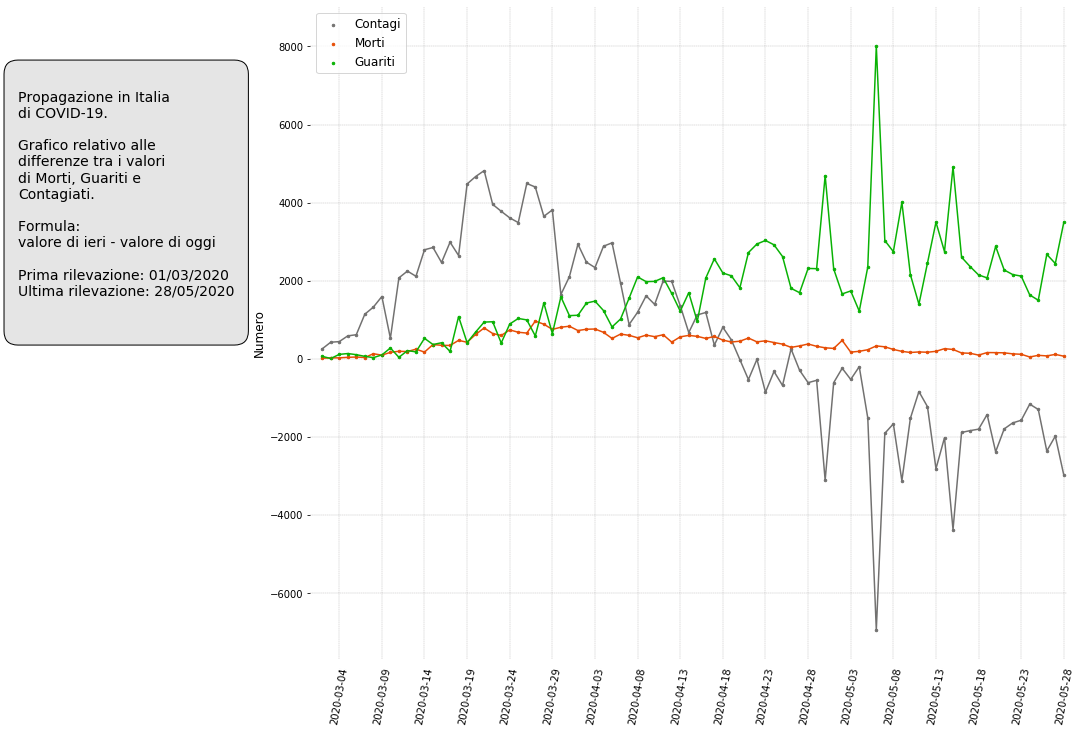

In [11]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df["timeStamp"].min().strftime(date_format)
max_date = df["timeStamp"].max().strftime(date_format)
total = f'{df["Totale"].max():n}'

data_sets = {
    "DailyInfected": {
        "df": df,
        "value column": "Casi attualiDiff",
        "label": "Contagi",
        "colors": ["#727170", "#727170"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "DailyDeaths": {
        "df": df,
        "value column": "MortiDiff",
        "label": "Morti",
        "colors": ["#e64d05", "#e64d05"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    },
    "DailyRecovered": {
        "df": df,
        "value column": "GuaritiDiff",
        "label": "Guariti",
        "colors": ["#09b204", "#09b204"],
        "size": 25,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}
# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(19, 12))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.45
                       ,width_ratios=[1, 7])
                       #,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
#ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Italia
di COVID-19.

Grafico relativo alle 
differenze tra i valori
di Morti, Guariti e 
Contagiati.

Formula: 
valore di ieri - valore di oggi

Prima rilevazione: {d1}
Ultima rilevazione: {d2}

""".format(d1=min_date, d2=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.7)

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
#c_virus_chart(ax[idx],x=x, y=df["Totale"])
composed_c_virus_chart(ax[idx], data_sets)


plt.savefig(os.path.join(images_path,"covid19_differences_chart.png")
           ,bbox_inches='tight')


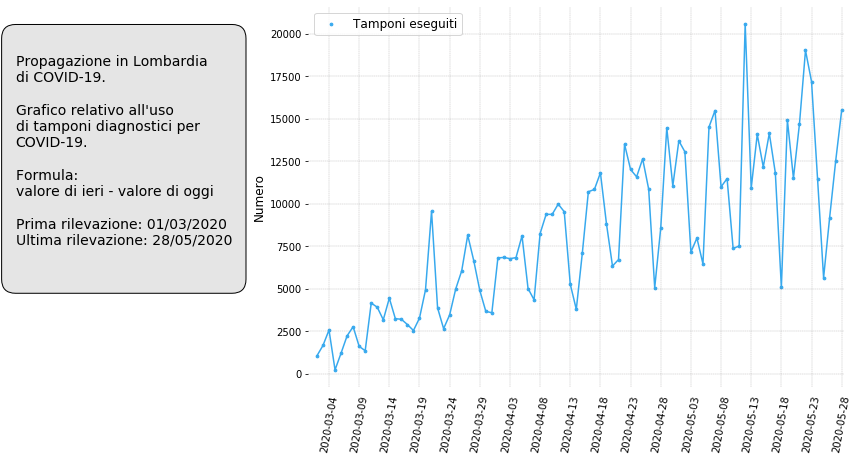

In [12]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

data_sets = {
    "DailyUsageOfDiagnosticDevices": {
        "df": df_lo,
        "value column": "TamponiDiff",
        "label": "Tamponi eseguiti",
        "colors": ["#37a9ee", "#37a9ee"],
        "size": 30,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
}
# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 7))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.7 
                       ,width_ratios=[1.1, 7])
                       #,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
#ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Lombardia
di COVID-19.

Grafico relativo all'uso
di tamponi diagnostici per
COVID-19.

Formula: 
valore di ieri - valore di oggi

Prima rilevazione: {d1}
Ultima rilevazione: {d2}

""".format(d1=min_date, d2=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.6)

idx += 1
x = df_lo["timeStamp"].dt.to_pydatetime()
#c_virus_chart(ax[idx],x=x, y=df["Totale"])
composed_c_virus_chart(ax[idx], data_sets)


plt.savefig(os.path.join(images_path,"covid19_differences_diagnostic_deviceschart.png")
           ,bbox_inches='tight')


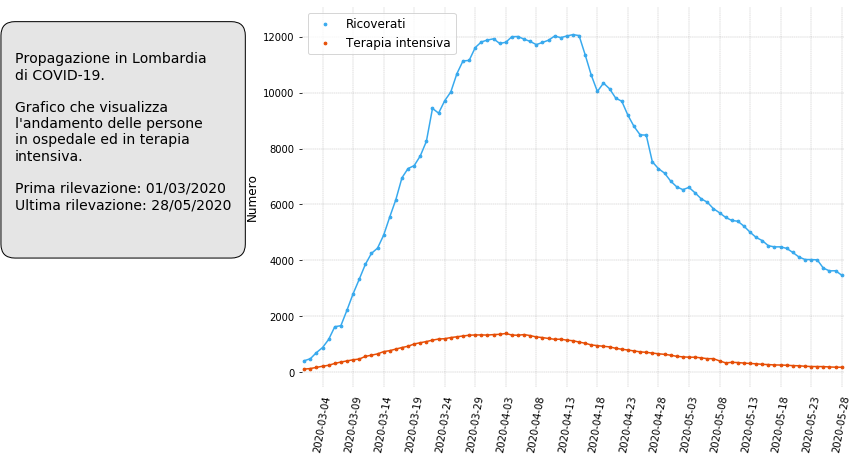

In [13]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

data_sets = {
    "Hospitalized": {
        "df": df_lo,
        "value column": "Ricoverati con sintomi",
        "label": "Ricoverati",
        "colors": ["#37a9ee", "#37a9ee"],
        "size": 30,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }
    ,"Intensive Care": {
        "df": df_lo,
        "value column": "Terapia intensiva",
        "label": "Terapia intensiva",
        "colors": ["#e64d05", "#e64d05"],
        "size": 30,
        "dot-shape": ".",
        "line-size": 1.5,
        "no_plot": False
    }

}
# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 7))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.7 
                       ,width_ratios=[1, 7])
                       #,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
#ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Lombardia
di COVID-19.

Grafico che visualizza 
l'andamento delle persone
in ospedale ed in terapia
intensiva.

Prima rilevazione: {d1}
Ultima rilevazione: {d2}

""".format(d1=min_date, d2=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.65)

idx += 1
x = df_lo["timeStamp"].dt.to_pydatetime()
#c_virus_chart(ax[idx],x=x, y=df["Totale"])
composed_c_virus_chart(ax[idx], data_sets)


plt.savefig(os.path.join(images_path
                         ,"covid19_Hospedalized_IntensiveCare_hospitalized.png")
                         #,pad_inches = 0.3
                         ,bbox_inches='tight')


In [14]:

df["MT Ratio"] = df[['Morti', 'Casi attuali']].apply(lambda row: round((row['Morti'] / row['Casi attuali']) * 100, 2), axis=1)
df["MG Ratio"] = df[['Morti', 'Guariti']].apply(lambda row: round((row['Morti'] / row['Guariti']) * 100, 2), axis=1)
df.columns

Index(['Data', 'Casi attuali', 'Morti', 'Guariti', 'Totale', 'timeStamp',
       'TimeDelta', 'TotalDiff', 'MortiDiff', 'GuaritiDiff',
       'Casi attualiDiff', 'MT Ratio', 'MG Ratio'],
      dtype='object')

In [15]:

df.head(8)

,Data,Casi attuali,Morti,Guariti,Totale,timeStamp,TimeDelta,TotalDiff,MortiDiff,GuaritiDiff,Casi attualiDiff,MT Ratio,MG Ratio
88,01/03/2020,1577,34,83,1694,2020-03-01,1,NaN,NaN,NaN,NaN,2.16,40.96
87,02/03/2020,1835,52,149,2036,2020-03-02,2,342.0,18.0,66.0,258.0,2.83,34.90
86,03/03/2020,2263,79,160,2502,2020-03-03,3,466.0,27.0,11.0,428.0,3.49,49.38
85,04/03/2020,2706,107,276,3089,2020-03-04,4,587.0,28.0,116.0,443.0,3.95,38.77
84,05/03/2020,3296,148,414,3858,2020-03-05,5,769.0,41.0,138.0,590.0,4.49,35.75
83,06/03/2020,3916,197,523,4636,2020-03-06,6,778.0,49.0,109.0,620.0,5.03,37.67
82,07/03/2020,5061,233,589,5883,2020-03-07,7,1247.0,36.0,66.0,1145.0,4.60,39.56
81,08/03/2020,6387,366,622,7375,2020-03-08,8,1492.0,133.0,33.0,1326.0,5.73,58.84
